In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras import optimizers, regularizers
from keras import activations
from keras import callbacks
from vis.utils import utils
from keras.callbacks import ModelCheckpoint
from IPython.display import clear_output
import numpy as np
import glob as glob
from skimage import color
from skimage import io
from skimage import exposure
from skimage import filters
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []
        
        #self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.train_acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure()
        plt.plot(self.x, self.losses, label="train_loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        plt.figure()
        plt.plot(self.x, self.train_acc, label="train_acc")
        plt.plot(self.x, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [3]:
# dimensions of our images.
img_width, img_height = 512, 512

train_data_dir = '../data/model/key19_cropped/train'
validation_data_dir = '../data/model/key19_cropped/val'
nb_train_samples = int(len(glob.glob(train_data_dir+'/*/*.png')))
nb_validation_samples = int(len(glob.glob(validation_data_dir+'/*/*.png')))
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(3, 3)))
model.add(Dropout(0.6))

model.add(Conv2D(16, (5, 5), input_shape=input_shape, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(3, 3)))
model.add(Dropout(0.6))


#model.add(Conv2D(16, (7, 7), padding='same',kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.6))

#model.add(Conv2D(34, (8, 8), padding='same',kernel_regularizer=regularizers.l2(0.001)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(AveragePooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 512, 512, 32)      320       
_________________________________________________________________
activation_9 (Activation)    (None, 512, 512, 32)      0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 170, 170, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 170, 170, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 170, 170, 16)      12816     
_________________________________________________________________
activation_10 (Activation)   (None, 170, 170, 16)      0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 56, 56, 16)        0         
__________

In [28]:
def preprocess_img(img):
    img = img.astype(np.float32) / 255.0
    img = np.reshape(img, (512,512))
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    img = img.reshape(img.shape + (1,))
    return img

In [29]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_img
        , 
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.25,
        zoom_range=0.25,
        fill_mode='nearest'
                                  )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_img)

In [30]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode =  "grayscale",
    class_mode='categorical')

Found 200 images belonging to 6 classes.


In [31]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    color_mode =  "grayscale",
    class_mode='categorical')

Found 84 images belonging to 6 classes.


In [32]:
checkpointer = ModelCheckpoint(filepath='../saved_weights/CNN_key19_weights.hdf5', verbose=0, save_best_only=True)

In [33]:
#model.load_weights('../saved_weights/CNN_key19_weights.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

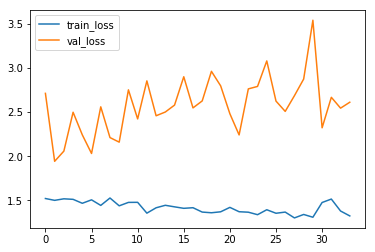

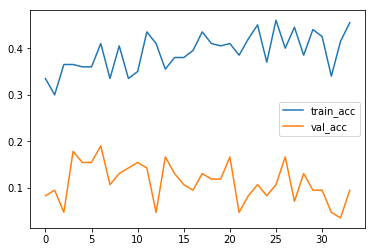

13/12 [================================] - 11s 849ms/step - loss: 1.3230 - acc: 0.4506 - val_loss: 2.6127 - val_acc: 0.0952
Epoch 35/50
 9/12 [=====================>........] - ETA: 2s - loss: 1.2393 - acc: 0.4653

KeyboardInterrupt: 

In [34]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size, verbose=1,
    callbacks=[checkpointer, plot_losses])

[ 1.  0.  0.  0.  0.  0.]


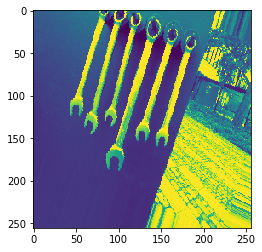

[ 0.  0.  0.  0.  0.  1.]


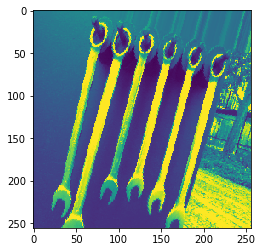

[ 0.  0.  0.  0.  0.  1.]


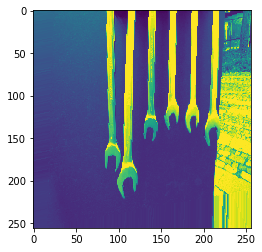

[ 1.  0.  0.  0.  0.  0.]


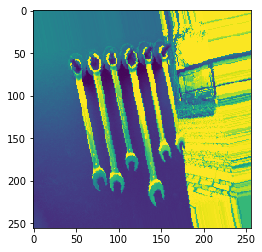

In [38]:
for batch, classes in train_generator:
    batch
    break
train_generator.filenames[0:4]
for i in range(0,4):
    print(classes[i])
    plt.figure()
    plt.imshow(batch[i][:,:,0])
    plt.show()

In [39]:
loss, accuracy = model.evaluate_generator(validation_generator, 
                                steps = nb_validation_samples // batch_size)
print()
print('Test Loss:', loss)
print('Test Accuracy', accuracy)


Test Loss: 4.14419015361
Test Accuracy 0.239436618879


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode =  "grayscale",
    shuffle = False,
    class_mode='categorical')

valid_pred_prob = model.predict_generator(validation_generator,steps = nb_validation_samples // batch_size, verbose=1)
valid_pred_labels = np.argmax(valid_pred_prob, axis=-1)

In [ ]:
acc = 1-np.sum(valid_pred_labels!=validation_generator.classes[0:valid_pred_labels.shape[0]])/valid_pred_labels.shape[0]
acc

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
idx = np.array(np.where(valid_pred_labels!=validation_generator.classes))
for i in range(0,idx.shape[1]):
    print(validation_generator.filenames[idx[0,i]])
    imgs=mpimg.imread(validation_data_dir+'/'+validation_generator.filenames[idx[0,i]])
    plt.figure()
    imgplot = plt.imshow(imgs)
    plt.show()

In [ ]:
from vis.visualization import visualize_activation

model.layers[-1].activation = activations.linear
model_vis = utils.apply_modifications(model)

layer_idx = -1

# Swap softmax with linear
model_vis.layers[layer_idx].activation = activations.linear
model_vis = utils.apply_modifications(model_vis)

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# well this looks like shit..!
img = visualize_activation(model_vis, layer_idx, filter_indices=2)
print(np.shape(img))
plt.imshow(img[:,:,0],cmap='gray')
plt.show()

img = visualize_activation(model_vis, layer_idx, filter_indices=2, max_iter=500, verbose=False)
plt.imshow(img[:,:,0],cmap='gray')
plt.show()

In [ ]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv2d_1'
layer_idx = utils.find_layer_idx(model_vis, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model_vis.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model_vis, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    #img = utils.draw_text(img, 'Filter {}'.format(idx))
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    

In [ ]:
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(stitched[:,:,0],cmap='gray')
plt.title(layer_name)
plt.show()

# Test data validation

In [ ]:
model.load_weights('../saved_weights/CNN_key19_weights.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer=AdamOpt,
              metrics=['accuracy'])

test_data_dir = '../data/model/key19/test'
nb_test_samples = int(len(glob.glob(test_data_dir+'/*/*.png')))

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_img)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    shuffle = False,
    color_mode =  "grayscale",
    class_mode='categorical')

test_pred_prob = model.predict_generator(test_generator,steps = 18 // 1, verbose=1)
test_pred_labels = np.argmax(test_pred_prob, axis=-1)

In [ ]:
acc = 1-np.sum(test_pred_labels!=test_generator.classes)/nb_test_samples
acc

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
idx = np.array(np.where(test_pred_labels!=test_generator.classes))
for i in range(0,idx.shape[1]):
    print(test_generator.filenames[idx[0,i]])
    imgs=mpimg.imread(test_data_dir+'/'+test_generator.filenames[idx[0,i]])
    plt.figure()
    imgplot = plt.imshow(imgs)
    plt.show()

In [ ]:
img_to_pred = img_to_array(load_img(test_data_dir+'/pos1/19_18_22_24_16_17_H_L_H_L_L_L_0837_0_1557.png',grayscale=True))

In [ ]:
img_to_pred.shape
plt.figure()
plt.imshow(img_to_pred[:,:,0])
plt.show()

test_pred_prob = model.predict(np.reshape(img_to_pred,(1,)+img_to_pred.shape))
print(test_pred_prob)



In [ ]:
from vis.utils import utils
from keras import activations

layer_idx = -1
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('../data/model/key19/train/pos4/17_18_22_19_24_16_H_L_H_L_H_L_42_0_321.png', target_size=(512, 512))
img2 = utils.load_img('../data/model/key19/train/pos4/22_18_17_19_16_24_L_L_L_L_L_L_10_0_7031.png', target_size=(512, 512))


f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=3, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')
plt.show()

# VIS test

In [ ]:
model.load_weights('../saved_weights/CNN_key19_weights.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer='adaGrad',
              metrics=['categorical_accuracy'])

input_img = img_to_array(load_img('../data/model/key19/train/pos4/17_18_22_19_24_16_H_L_H_L_H_L_42_0_321.png',grayscale=True))
print(input_img.shape)


from keras import backend as K

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = 'conv2d_3'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])
print(layer_output[:, :, :, filter_index])


# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])